In [1]:
import pandas as pd

df = pd.read_parquet('data/preprocessed.parquet')

In [2]:
df.shape

(4922564, 12)

In [3]:
df.head()

,Bwd Packet Length Std,Bwd Packet Length Max,Packet Length Std,Packet Length Variance,Bwd Packet Length Mean,Avg Bwd Segment Size,Packet Length Max,Avg Packet Size,Init Fwd Win Bytes,Packet Length Mean,Idle Std,ClassLabel
0,119.511505,207.0,107.527443,11562.151367,103.5,103.5,233.0,81.636360,8192,74.833336,0.0,0
1,884.500610,1532.0,547.842529,300131.437500,766.0,766.0,1532.0,286.153839,8192,265.714294,0.0,0
2,782.347229,1518.0,684.968994,469182.531250,508.0,508.0,1552.0,412.133331,8192,386.375000,0.0,0
3,814.063904,1410.0,689.943359,476021.875000,705.0,705.0,1410.0,512.000000,8192,469.333344,0.0,0
4,0.000000,6.0,0.000000,0.000000,6.0,6.0,6.0,9.000000,2053,6.000000,0.0,0


In [4]:
df.dtypes

Bwd Packet Length Std     float32
Bwd Packet Length Max     float64
Packet Length Std         float32
Packet Length Variance    float32
Bwd Packet Length Mean    float32
Avg Bwd Segment Size      float32
Packet Length Max         float64
Avg Packet Size           float32
Init Fwd Win Bytes          int32
Packet Length Mean        float32
Idle Std                  float32
ClassLabel                  int64
dtype: object

In [5]:
min_count = df['ClassLabel'].value_counts().min()
df['ClassLabel'].value_counts(), min_count

(ClassLabel
 0    4099806
 3     575152
 1     144448
 2     103158
 Name: count, dtype: int64,
 np.int64(103158))

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['ClassLabel'], axis=1)
y = df['ClassLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3445794, 11), (1476770, 11), (3445794,), (1476770,))

In [7]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [8]:
numerical_cols = X.select_dtypes(include='number').columns.tolist()
numerical_cols

['Bwd Packet Length Std',
 'Bwd Packet Length Max',
 'Packet Length Std',
 'Packet Length Variance',
 'Bwd Packet Length Mean',
 'Avg Bwd Segment Size',
 'Packet Length Max',
 'Avg Packet Size',
 'Init Fwd Win Bytes',
 'Packet Length Mean',
 'Idle Std']

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SciPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import os

allocated_cpus = os.cpu_count() // 2

scaling_transformer = SciPipeline(
    steps=[("scaler", MinMaxScaler(feature_range=(0, 1)))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("scaling_transformer", scaling_transformer, numerical_cols),
    ],
    remainder="passthrough",  # ensures other columns, if any, are not dropped
)

pipeline = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        ("under", RandomUnderSampler(random_state=69, sampling_strategy="majority")),
        ("classifier", GaussianNB()),
    ]
)

# Define parameter grid for GridSearchCV
param_grid = [
    {
        "classifier": [
            LGBMClassifier(
                n_jobs=allocated_cpus,
            )
        ],
        "classifier__num_leaves": [25, 50],
        "classifier__n_estimators": [25, 50],
        "classifier__learning_rate": [0.1, 0.01],
    },
    {
        "classifier": [XGBClassifier(n_jobs=allocated_cpus)],
        "classifier__max_depth": [3, 6],
        "classifier__n_estimators": [25, 50],
        "classifier__learning_rate": [0.1, 0.01],
    },
    {"classifier": [GaussianNB()]},
]

In [10]:
from collections import Counter

class_counts = Counter(y_train)

print(class_counts)

Counter({0: 2870057, 3: 402453, 1: 101200, 2: 72084})


In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=3, random_state=69, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='f1_macro', n_jobs=os.cpu_count()//2, verbose=3)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
grid_search.best_estimator_

Fitting 3 folds for each of 17 candidates, totalling 51 fits


c:\Users\neucl\Dev\AIT\CP_Projects\ID-LD-ML\project-env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 647821, number of used features: 11
[LightGBM] [Info] Start training from score -2.195782
[LightGBM] [Info] Start training from score -1.856516
[LightGBM] [Info] Start training from score -2.195782
[LightGBM] [Info] Start training from score -0.476036
Best parameters found:  {'classifier': LGBMClassifier(n_jobs=6), 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50, 'classifier__num_leaves': 25}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Bwd Packet Length Std',
                                                   'Bwd Packet Length Max',
                                                   'Packet Length Std',
                                                   'Packet Length Variance',
                                                   'Bwd Packet Length Mean',
                                                   'Avg Bwd Segment Size',
                                                   'Packet Length Max',
                                                   'Avg Packet Size',
                                                   'Init Fwd Win Bytes',
                                                   'Packet Length Mean',
                                                   'Idle Std'])])),
                ('under',
                 RandomUnderSampler(random_state=69,
                                    sampling_strategy='majority')),
                ('classifier',
                 LGBMClassifier(n_estimators=50, n_jobs=6, num_leaves=25))])

In [12]:
import json
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(json.dumps(classification_report(y_test, y_pred, output_dict=True), indent=4))

{
    "0": {
        "precision": 0.9998533120907509,
        "recall": 0.9976954646842567,
        "f1-score": 0.9987732228826901,
        "support": 1229749.0
    },
    "1": {
        "precision": 0.9765812197658122,
        "recall": 0.9989363669996301,
        "f1-score": 0.9876323068833871,
        "support": 43248.0
    },
    "2": {
        "precision": 0.9734244257106146,
        "recall": 0.9995816438179829,
        "f1-score": 0.986329644507248,
        "support": 31074.0
    },
    "3": {
        "precision": 0.9943928357383246,
        "recall": 0.9991661793061917,
        "f1-score": 0.9967737929162082,
        "support": 172699.0
    },
    "accuracy": 0.9979434847674317,
    "macro avg": {
        "precision": 0.9860629483263755,
        "recall": 0.9988449137020154,
        "f1-score": 0.9923772417973833,
        "support": 1476770.0
    },
    "weighted avg": {
        "precision": 0.9979770947584427,
        "recall": 0.9979434847674317,
        "f1-score": 0.9979512

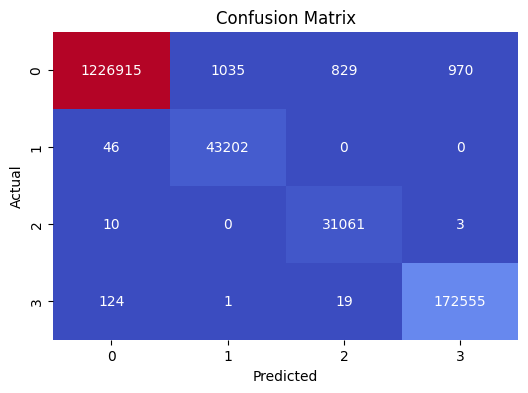

In [13]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [15]:
import pickle
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [16]:
with open('models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [17]:
data_to_predict = X_test.iloc[991].tolist()

In [18]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [19]:
data_to_predict_df = pd.DataFrame([data_to_predict], columns=X_test.columns)
loaded_model.predict(data_to_predict_df)

array([0])

In [20]:
y_test.iloc[991]

np.int64(0)

In [21]:
X_test.columns

Index(['Bwd Packet Length Std', 'Bwd Packet Length Max', 'Packet Length Std',
       'Packet Length Variance', 'Bwd Packet Length Mean',
       'Avg Bwd Segment Size', 'Packet Length Max', 'Avg Packet Size',
       'Init Fwd Win Bytes', 'Packet Length Mean', 'Idle Std'],
      dtype='object')